# Humpback Whale Identification - CNN with Keras
This kernel is based on [Anezka Kolaceke](https://www.kaggle.com/anezka)'s awesome work: [CNN with Keras for Humpback Whale ID](https://www.kaggle.com/anezka/cnn-with-keras-for-humpback-whale-id)

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
os.listdir("data/")

['test', 'train.csv', 'train']

In [3]:
train_df = pd.read_csv("data/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [4]:
# this will show the amount of images in some of the categories
train_df.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [5]:
# now the new_whale data points will be removed from the dataframe
I_dont_want_new_whales = train_df['Id'] != 'new_whale'
train_df = train_df[I_dont_want_new_whales]
train_df.Id.value_counts().head()

w_23a388d    73
w_9b5109b    65
w_9c506f6    62
w_0369a5c    61
w_700ebb4    57
Name: Id, dtype: int64

In [6]:
img_size = 45

In [7]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, img_size, img_size, 3))
    count = 0
    
    for fig in data['Image']:
        img = image.load_img("data/"+dataset+"/"+fig, target_size=(img_size, img_size, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train

In [8]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [9]:
# This chunk of code was added to resolve the error "OSError: image file is truncated" in the below cell
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
X = prepareImages(train_df, train_df.shape[0], "train")
X /= 255

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  0823f9df3.jpg
Processing image:  1001 ,  10b694367.jpg
Processing image:  1501 ,  195805c52.jpg
Processing image:  2001 ,  21e28ae02.jpg
Processing image:  2501 ,  2a1146baa.jpg
Processing image:  3001 ,  32533a7fb.jpg
Processing image:  3501 ,  3a8173905.jpg
Processing image:  4001 ,  42f134dea.jpg
Processing image:  4501 ,  4aa4de13a.jpg
Processing image:  5001 ,  5297b6c40.jpg
Processing image:  5501 ,  5b7f0e6e6.jpg
Processing image:  6001 ,  6311688b7.jpg
Processing image:  6501 ,  6b29760e3.jpg
Processing image:  7001 ,  7390cbfab.jpg
Processing image:  7501 ,  7b949f512.jpg
Processing image:  8001 ,  83336c385.jpg
Processing image:  8501 ,  8b369569b.jpg
Processing image:  9001 ,  92f450203.jpg
Processing image:  9501 ,  9b984102a.jpg
Processing image:  10001 ,  a39babc55.jpg
Processing image:  10501 ,  ab6f8bddd.jpg
Processing image:  11001 ,  b36da6f7c.jpg
Processing image:  11501 ,  bb9ffa8b2.jpg

In [11]:
y, label_encoder = prepare_labels(train_df['Id'])

In [12]:
y.shape

(15697, 5004)

In [13]:
from keras.applications.resnet50 import ResNet50
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.optimizers import Adam

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [14]:
def pre_model():
    base_model = ResNet50(input_shape=(img_size, img_size, 3), weights=None, classes=5004)
    base_model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy', metrics=[categorical_crossentropy, categorical_accuracy, top_5_accuracy])
    return base_model

In [15]:
model = pre_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 45, 45, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 51, 51, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 23, 23, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 23, 23, 64)   256         conv1[0][0]                      
_____________________________________

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

callback = [reduce_lr]

In [18]:
history = model.fit(X, y, epochs=50, batch_size=50, verbose=1, validation_split=0.1, callbacks=callback)

Instructions for updating:
Use tf.cast instead.
Train on 14127 samples, validate on 1570 samples
Epoch 1/50
14127/14127 [==============================] - 97s 7ms/step - loss: 8.6013 - categorical_crossentropy: 8.6013 - categorical_accuracy: 0.0035 - top_5_accuracy: 0.0382 - val_loss: 15.7436 - val_categorical_crossentropy: 15.7436 - val_categorical_accuracy: 0.0032 - val_top_5_accuracy: 0.9522
Epoch 2/50
14127/14127 [==============================] - 78s 6ms/step - loss: 8.2008 - categorical_crossentropy: 8.2008 - categorical_accuracy: 0.0067 - top_5_accuracy: 0.0447 - val_loss: 9.1284 - val_categorical_crossentropy: 9.1284 - val_categorical_accuracy: 0.0019 - val_top_5_accuracy: 0.1019
Epoch 3/50
14127/14127 [==============================] - 78s 6ms/step - loss: 7.9604 - categorical_crossentropy: 7.9604 - categorical_accuracy: 0.0083 - top_5_accuracy: 0.0502 - val_loss: 8.4055 - val_categorical_crossentropy: 8.4055 - val_categorical_accuracy: 0.0108 - val_top_5_accuracy: 0.0344
Epoc

14127/14127 [==============================] - 78s 6ms/step - loss: 7.1959 - categorical_crossentropy: 7.1959 - categorical_accuracy: 0.0140 - top_5_accuracy: 0.0643 - val_loss: 8.9272 - val_categorical_crossentropy: 8.9272 - val_categorical_accuracy: 0.0159 - val_top_5_accuracy: 0.0573
Epoch 28/50
14127/14127 [==============================] - 78s 6ms/step - loss: 7.2082 - categorical_crossentropy: 7.2082 - categorical_accuracy: 0.0127 - top_5_accuracy: 0.0642 - val_loss: 8.9243 - val_categorical_crossentropy: 8.9243 - val_categorical_accuracy: 0.0159 - val_top_5_accuracy: 0.0567
Epoch 29/50
14127/14127 [==============================] - 78s 6ms/step - loss: 7.2046 - categorical_crossentropy: 7.2046 - categorical_accuracy: 0.0142 - top_5_accuracy: 0.0658 - val_loss: 8.9258 - val_categorical_crossentropy: 8.9258 - val_categorical_accuracy: 0.0159 - val_top_5_accuracy: 0.0580
Epoch 30/50
14127/14127 [==============================] - 78s 6ms/step - loss: 7.1987 - categorical_crossentrop

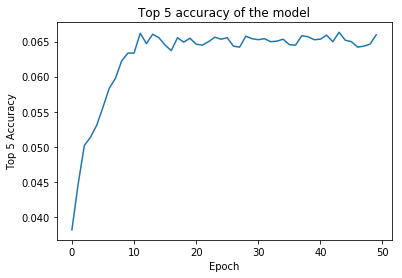

In [19]:
plt.plot(history.history['top_5_accuracy'])
# plt.plot(history.history['acc'])
plt.title('Top 5 accuracy of the model')
plt.ylabel('Top 5 Accuracy')
plt.xlabel('Epoch')
plt.show()

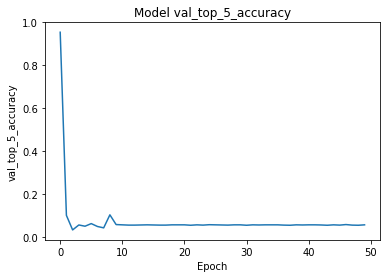

In [20]:
plt.plot(history.history['val_top_5_accuracy'])
plt.title('Model val_top_5_accuracy')
plt.ylabel('val_top_5_accuracy')
plt.xlabel('Epoch')
plt.show()

In [21]:
# Now an optimal threshold for the new_whale label will be determined.
# First the entire training set (includeing new_whales) will be imported
train_df = pd.read_csv("data/train.csv")
X = prepareImages(train_df, train_df.shape[0], "train")
X /= 255
y = train_df['Id']

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg
Processing image:  1001 ,  09cacb84d.jpg
Processing image:  1501 ,  0ef961892.jpg
Processing image:  2001 ,  141b56a1a.jpg
Processing image:  2501 ,  199a417aa.jpg
Processing image:  3001 ,  1ec170983.jpg
Processing image:  3501 ,  23f084b93.jpg
Processing image:  4001 ,  29163ad0b.jpg
Processing image:  4501 ,  2e0fab120.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  5501 ,  3842d71dc.jpg
Processing image:  6001 ,  3d7f4c7d5.jpg
Processing image:  6501 ,  425f763ca.jpg
Processing image:  7001 ,  4714400cd.jpg
Processing image:  7501 ,  4c082fbdf.jpg
Processing image:  8001 ,  50c683e23.jpg
Processing image:  8501 ,  560d986ad.jpg
Processing image:  9001 ,  5b68c83ed.jpg
Processing image:  9501 ,  60410f111.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  10501 ,  6a572256c.jpg
Processing image:  11001 ,  6f96f55b6.jpg
Processing image:  11501 ,  74da2b511.jpg

In [23]:
import gc
gc.collect()

0

In [24]:
# the map5 function will be used to evaluate the predictions
def map5(X, y):
    score = 0
    for i in range(X.shape[0]):
        pred = X[i]
        lp = label_encoder.inverse_transform(pred.argsort()[-5:][::-1])
        p2 = pred[:]
        ind = pred.argsort()[-5:][::-1]
        s = sum(p2[ind] < th)
        if s != 0:
            for j in range(lp.size):
                if p2[ind[j]] < th:
                    k = j
                    lp[k] = 'new_whale'
                    break
# the below line is commented to avoid the error "UnboundLocalError: local variable 'k' referenced before assignment"
#            lp[k] = 'new_whale'
        #pred = X[i].argsort()[-5:][::-1]
        for j in range(lp.size):
            if lp[j] == y[i]:
                score += (5 - j)/5
                break
    return score/X.shape[0]

# now the optimal threshold will be determined by calculating the map5 score for each threshold value.
predictions = model.predict(np.array(X), verbose=1, batch_size=50)
best_th = 0
best_score = 0
for th in np.arange(0.1, 0.91, 0.01):
    #predictions[:,0] = th
    score = map5(predictions, y)
    if score > best_score:
        best_score = score
        best_th = th
    print("Threshold = {:.3f}, MAP5 = {:.3f}".format(th,score))

25361/25361 [==============================] - 28s 1ms/step
Threshold = 0.100, MAP5 = 0.391
Threshold = 0.110, MAP5 = 0.391
Threshold = 0.120, MAP5 = 0.391
Threshold = 0.130, MAP5 = 0.391
Threshold = 0.140, MAP5 = 0.391
Threshold = 0.150, MAP5 = 0.391
Threshold = 0.160, MAP5 = 0.391
Threshold = 0.170, MAP5 = 0.391
Threshold = 0.180, MAP5 = 0.391
Threshold = 0.190, MAP5 = 0.391
Threshold = 0.200, MAP5 = 0.391
Threshold = 0.210, MAP5 = 0.391
Threshold = 0.220, MAP5 = 0.391
Threshold = 0.230, MAP5 = 0.391
Threshold = 0.240, MAP5 = 0.391
Threshold = 0.250, MAP5 = 0.391
Threshold = 0.260, MAP5 = 0.391
Threshold = 0.270, MAP5 = 0.391
Threshold = 0.280, MAP5 = 0.391
Threshold = 0.290, MAP5 = 0.391
Threshold = 0.300, MAP5 = 0.391
Threshold = 0.310, MAP5 = 0.391
Threshold = 0.320, MAP5 = 0.391
Threshold = 0.330, MAP5 = 0.391
Threshold = 0.340, MAP5 = 0.391
Threshold = 0.350, MAP5 = 0.391
Threshold = 0.360, MAP5 = 0.391
Threshold = 0.370, MAP5 = 0.391
Threshold = 0.380, MAP5 = 0.391
Threshold = 

In [25]:
test = os.listdir("data/test/")
print(len(test))

7960


In [26]:
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

In [28]:
gc.collect()

0

In [29]:
X = prepareImages(test_df, test_df.shape[0], "test")
X /= 255

Preparing images
Processing image:  1 ,  bfd521ee0.jpg
Processing image:  501 ,  f124e20f9.jpg
Processing image:  1001 ,  7fd675d90.jpg
Processing image:  1501 ,  f15cc97a7.jpg
Processing image:  2001 ,  b0ced16b2.jpg
Processing image:  2501 ,  5b8f3af0a.jpg
Processing image:  3001 ,  00ccb53ec.jpg
Processing image:  3501 ,  378f63826.jpg
Processing image:  4001 ,  a8e72eb20.jpg
Processing image:  4501 ,  599fb6ecf.jpg
Processing image:  5001 ,  292b2b27d.jpg
Processing image:  5501 ,  2aeee8b9f.jpg
Processing image:  6001 ,  ea046b98d.jpg
Processing image:  6501 ,  43e35c1b6.jpg
Processing image:  7001 ,  e67b3fc69.jpg
Processing image:  7501 ,  bc605917b.jpg


In [30]:
predictions = model.predict(np.array(X), verbose=1, batch_size=50)

7960/7960 [==============================] - 9s 1ms/step


In [31]:
for i, pred in enumerate(predictions):
    lp = label_encoder.inverse_transform(pred.argsort()[-5:][::-1])
    p2 = pred[:]
    ind = pred.argsort()[-5:][::-1]
    s = sum(p2[ind] < best_th)
    if s != 0:
        for j in range(lp.size):
            if p2[ind[j]] < best_th:
                k = j
                lp[k] = 'new_whale'
                break
#        lp[k] = 'new_whale'
    test_df.loc[i, 'Id'] = ' '.join(lp)

In [24]:
#for i, pred in enumerate(predictions):
#    test_df.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))

In [32]:
print(test_df.head(10))
test_df.to_csv('submission.csv', index=False)

           Image                                                 Id
0  bfd521ee0.jpg  new_whale w_564a34b w_88e4537 w_990921b w_9c506f6
1  02b063a20.jpg  new_whale w_d405854 w_9b5109b w_700ebb4 w_f0fe284
2  48dc51d2a.jpg  new_whale w_9b5109b w_23a388d w_a9304b9 w_d72771c
3  f553318b3.jpg  new_whale w_d405854 w_6e97ef4 w_2b069ba w_59052ad
4  1546729ec.jpg  new_whale w_f0fe284 w_d405854 w_0fdf741 w_789c969
5  8cc48ab02.jpg  new_whale w_564a34b w_9c506f6 w_88e4537 w_fd3e556
6  de74478c6.jpg  new_whale w_789c969 w_700ebb4 w_343f088 w_23a388d
7  211d8987b.jpg  new_whale w_700ebb4 w_343f088 w_0369a5c w_789c969
8  b0675b37a.jpg  new_whale w_a9304b9 w_700ebb4 w_343f088 w_9b5109b
9  8c10e784e.jpg  new_whale w_789c969 w_700ebb4 w_f0fe284 w_3de579a
